<center><h1>UVA Psychology Capstone   </h1></center>
<center><h1>Brain Computer Interface with Scale Invariant Temporal History</h1></center>

#### A preliminary Deep_iSith model that trains on EEG data.
Gaurav Anand, Arshiya Ansari, Beverly Dobrenz, Yibo Wang  
data source: Grasp-and-Lift EEG  
https://www.kaggle.com/c/grasp-and-lift-eeg-detection/data  
For now, only consider one subject and one trial at a time.
Predict only one event/channel a time (since there are events overlapping), and incorporate sliding-window standardization and filtering 
The code is tested on Rivanna with GPU. (may needs some work with CPU only)


In [9]:
# currently use this as a work around for Rivanna
from SITH_Layer_master.sith import iSITH
from SITH_Layer_master.sith import deep_isith

In [10]:
# preprocessing
import mne
import numpy as np
import math
import pandas as pd
from mne.io import RawArray
from mne.channels import make_standard_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs, concatenate_raws, pick_types
from mne.decoding import CSP

# pytorch
import torch
import torch.nn
import torch.nn.functional as F
ttype = torch.cuda.DoubleTensor if torch.cuda.is_available() else torch.DoubleTensor
labeltype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
print(ttype)

# deep_iSITH is being used here, not deep_sith
#from sith import iSITH
#from sith import DeepSITH

import matplotlib.pyplot as plt
%matplotlib inline

# training 
from torch import nn as nn
from math import factorial
import random
import seaborn as sn
import os 
from os.path import join
import glob

# validation
from sklearn.metrics import roc_curve, auc, roc_auc_score, matthews_corrcoef,confusion_matrix,plot_roc_curve


from tqdm.notebook import tqdm
import pickle
sn.set_context("poster")

<class 'torch.cuda.DoubleTensor'>


## A useful funciton to read the csv data and save to a mne raw file

In [11]:

def creat_mne_raw_object(fname,read_events=True):
    """
    obtained from @author: alexandrebarachant
    https://www.kaggle.com/alexandrebarachant/beat-the-benchmark-0-67
    Create a mne raw instance from csv file.
    Make sure the events and data files are in the same folder
    data are transformed into microvolts
    """
    # Read EEG file
    data = pd.read_csv(fname)
    
    # get chanel names
    ch_names = list(data.columns[1:])
    
    # read EEG standard montage from mne
    #montage = make_standard_montage('standard_1005')

    ch_type = ['eeg']*len(ch_names)
    data = 1e-6*np.array(data[ch_names]).T
    
    if read_events:
        # events file
        ev_fname = fname.replace('_data','_events')
        # read event file
        events = pd.read_csv(ev_fname)
        events_names = events.columns[1:]
        events_data = np.array(events[events_names]).T
        # define channel type, the first is EEG, the last 6 are stimulations
        ch_type.extend(['stim']*6)
        ch_names.extend(events_names)
        # concatenate event file and data
        data = np.concatenate((data,events_data))
        
    # create and populate MNE info structure
    info = create_info(ch_names,sfreq=500.0, ch_types=ch_type)
    #info['filename'] = fname
    print(info)
    # create raw object 
    raw = RawArray(data,info,verbose=False)
    #print(data)
    return raw

## plot and testing


<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG, 6 STIM
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 38
 projs: []
 sfreq: 500.0 Hz
>
34 events found
Event IDs: [1]


<ipython-input-11-29a39170704c>:35: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
  info = create_info(ch_names,sfreq=500.0, ch_types=ch_type)


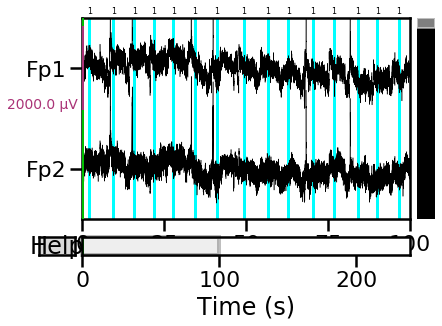

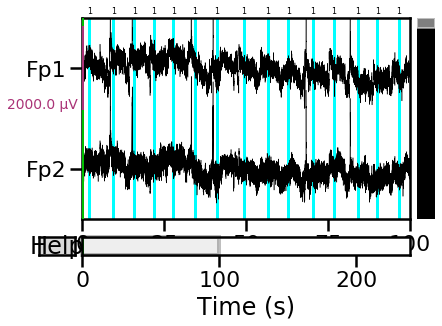

In [12]:
# testing
raw = creat_mne_raw_object("grasp-and-lift-eeg-detection/subj1_series1_data.csv")
# plotting 
# scaling is necessary to show the graphs properly
# vertical lines indicate a event
scalings = {'eeg': 10e-4}
events = mne.find_events(raw, stim_channel=['HandStart',])
raw.plot(n_channels=2,scalings=scalings,duration=100.0, events= events)

## Filtering and rolling-window standardization

In [13]:
# ---------- Creating filtered and unfiltered data sets --------
window_size = 1000
l_freq = 0
h_freq = 30
filtered_X = raw.filter(l_freq=l_freq, h_freq= h_freq, method='fir',phase="minimum",
                        verbose=True, picks = [x for x in range(32)])
filtered_X = filtered_X.to_data_frame().drop(['time'],axis=1)
# only the first 32 channels to standardize
filtered_X = filtered_X.iloc[:,0:32]
filtered_standardized = ((filtered_X - filtered_X.rolling(window_size).mean()) / filtered_X.rolling(window_size).std()).dropna()

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, non-linear phase, causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper transition bandwidth: 7.50 Hz
- Filter length: 221 samples (0.442 sec)



In [14]:
filtered_standardized

,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
999,1.031571,1.280361,0.617855,1.164276,0.912030,0.990129,1.150323,1.158929,0.670391,1.701430,...,0.619544,0.468090,0.772429,1.019172,0.766136,0.734477,0.520733,0.628802,0.827175,0.422620
1000,1.010448,1.231313,0.618561,1.132367,0.744505,1.196898,1.197364,1.176155,0.700812,1.527037,...,0.684344,0.527521,0.781263,1.027721,0.812889,0.859356,0.590786,0.671824,0.857371,0.494199
1001,1.016221,1.198910,0.678379,1.090304,0.616306,1.402533,1.270653,1.140259,0.731564,1.346011,...,0.740208,0.580583,0.791933,1.038043,0.863866,0.952099,0.645469,0.706837,0.892432,0.565763
1002,1.051099,1.186021,0.784441,1.053695,0.527972,1.587168,1.345716,1.048808,0.749681,1.169720,...,0.785523,0.619052,0.797361,1.046001,0.913430,1.006778,0.682453,0.728961,0.926345,0.632636
1003,1.105462,1.204738,0.927944,1.036482,0.488100,1.728357,1.398437,0.927563,0.759413,1.015445,...,0.817524,0.638625,0.795020,1.047846,0.951086,1.020228,0.697887,0.732387,0.950396,0.679624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119491,-0.658550,-0.605999,-0.777989,-0.433163,-0.340865,-0.614284,-0.017532,-1.092015,-0.849936,0.197247,...,-1.841331,-0.953851,-0.736728,-0.205243,-0.505544,-1.107324,-1.435897,-0.378809,-0.244435,-0.709385
119492,-0.650356,-0.514128,-0.702144,-0.500905,-0.300564,-0.639292,0.172528,-1.189050,-0.889657,0.201142,...,-1.843347,-1.017954,-0.859823,-0.233698,-0.473399,-1.118008,-1.469555,-0.409201,-0.241755,-0.651338
119493,-0.637504,-0.420592,-0.626687,-0.538477,-0.248671,-0.611915,0.363169,-1.242418,-0.914708,0.158611,...,-1.756827,-1.023102,-0.963541,-0.252521,-0.426135,-1.051830,-1.460973,-0.411163,-0.218931,-0.580990
119494,-0.622106,-0.337702,-0.558788,-0.545096,-0.195287,-0.548021,0.520028,-1.238777,-0.925427,0.065021,...,-1.588997,-0.983849,-1.048277,-0.266651,-0.378049,-0.940220,-1.432735,-0.404630,-0.192425,-0.511341


In [32]:
# filtered and stardardized training data
nClass = 3


input_signal = filtered_standardized.to_numpy()
input_signal = np.swapaxes(input_signal,0,1)

print(input_signal.shape)

data = raw.get_data()
target_signal = target_signal_val =data[32+nClass-1,window_size-1:] # use only one channel
print(target_signal.shape)

(32, 118497)
(118497,)


## Prepare the data for training and testing
A fairly simple toy model: try to predict event a time since some events are overlapping.   
    The **input** signal needs to be in correct format: **[nbatch x 1 x nfeutures x time]** pytorch tensor.
    The inputs to the models are the time series EEG signals. All channels will be
    concatnated into one channel by iSith.    
    The **targets** are inputed separately with **[nClasses x time]**  tensor. The target is either 0 or 1 at any time point for each event channel. Needs to relabel them into $nClasses \in \{1,2 ... ,K\}$.     
    **Note: Dimention of the input tensors  (batch, MAGIC, features, sequence). The second "magic" dimention will always be 1 in order for this to quickly calculate the output of the SITH layer.**     
    For this model batch should be one because we only feed one trial of one subject.    

In [33]:
# # old without preprocessing
# # input data, for this toy model, only consider the first 10000 unprocessed time points
# ## channels 32 to 38 are targets, for this model. Only predict one event a time

# nClass = 2
# data = raw.get_data()
# input_signal = data[0:32,:]
# print(input_signal.shape)
# target_signal = target_signal_val =data[32+nClass-1,:] # use all six channels
# print(target_signal.shape)

## Reformat the data into pytorch tensors
target should be binary labels

In [34]:
# reformatt into tensor
input_tensor = ttype(input_signal.reshape(1,1,input_signal.shape[0],-1))
target_tensor = labeltype(target_signal.reshape(-1))

print(input_tensor.shape, target_tensor.shape)

torch.Size([1, 1, 32, 118497]) torch.Size([118497])


In [35]:
np.unique(target_signal,return_counts=True)

(array([0., 1.]), array([113397,   5100]))

## Random split to training and validation 
(for now, just do first 50% as training and last 50% as validation for simplicity)  
Makes sure to update this funciton later for random partition

In [36]:
percentage_training = 0.7
cut = int((input_signal.shape[1])*percentage_training)
# for now, pick one batch as testing
train_X =  input_tensor[:,:,:,:cut]
train_Y = target_tensor[:cut]
test_X =  input_tensor[:,:,:,cut:]
test_Y = target_tensor[cut:]
print(train_X.shape,train_Y.shape,test_X.shape,test_Y.shape)

torch.Size([1, 1, 32, 82947]) torch.Size([82947]) torch.Size([1, 1, 32, 35550]) torch.Size([35550])


## Define training, testing functions, and Deep_sith models
**Training**:
Currently only use one batch. Will add batch processing ability later.     
**Validation**:   
The performance metric used here is **matthews correlation coeefficient** since the data are imbanlanced.  
Signals need to be in correct format. validation input: [nbatch x 1 x nFeutures x time] tensor.
The validation target has dimension of [time] tensor, in which each entry should be one of the numbers in 
{0,1,2, ... K} at any time point.  

In [37]:
def train(model, ttype, train_sig, train_ans, 
          test_sig, test_ans, optimizer, loss_func, 
          epoch, loss_buffer_size=4, batch_size=1, 
        prog_bar=None):
    assert(loss_buffer_size%batch_size==0)
    
    loss_track = {"name":[],
                  "loss":[],
                  "acc":[],
                  }
    # make sure tensor types are correct
    #train_sig = train_sig.type(torch.DoubleTensor)
    #train_ans = train_ans.type(torch.LongTensor)
    
    #--------------------- Training --------------------#
    #currently we only have 1 batch, so no batch processing.
    model.train()
    
    #print(target.shape)
    optimizer.zero_grad()
    
    # make sure the out put is in the right format
    # needs to be in [nbatch x 1 x nfeutures x time]
    # unsqueeze(0) to add back the first dimension if necessary
    ## out = model(sig.unsqueeze(0))
    out = model(train_sig)
    # permute out to the correct format
    out = out[-1,:,:]
    #print(train_ans.shape)
    #print(out.shape)
    loss = loss_func(out, train_ans)
    #print(loss)
    loss.backward()
    optimizer.step()

    
    #--- Record name, loss, validation accuracy --#
    loss_track['name'].append(model.__class__.__name__)
    loss_track['loss'].append(loss.mean().detach().cpu().numpy())
    
    # call test_model for validation accuracy calculations

    acc = test_model(model, test_sig,test_ans)
    loss_track['acc'].append(acc)
       
    # ----  update training progress -------------#
    if  prog_bar is not None:
        # Update progress_bar
        s = "Epoch {},Loss: {:.8f}, Validation AUC{}: "
        format_list = [epoch, loss.mean().detach().cpu().numpy(), acc]         
        s = s.format(*format_list)
        prog_bar.set_description(s)

    return loss_track

def test_model(model, signal,target):
    """
    Test for accuracy
    Iterate through each batch and make prediciton and calculate performance metrics
    Use **matthews correlation coeefficient** since the data are imbanlanced
    Again 
    Signals need to be in correct format. validation input: [nbatch x 1 x nFeutures x time] tensor.

    The target has dimension of [time] tensor, in which each entry should be one of the numbers in 
    {0,1,2, ... K} at any time point.  
    
    """
    matthew =[]
    
    #signal = signal.type(torch.DoubleTensor)
    #target = target.type(torch.LongTensor)
    #print(targets.shape)
    out = model(signal)
    # permute out to the correct format
    out = out[-1,:,:]
    # pass through a softmax to tansform to probability
    res = torch.nn.functional.softmax(out, dim=1)
    #print(res.shape)
    # The class with 1 as label
    y_pred = res[:,1].detach().cpu().numpy()
    y_true = target.detach().cpu().numpy()
    auc = roc_auc_score(y_true = y_true, y_score = y_pred)

    return auc

## Build a DeepSITH_Tracker based on DeepSITH

In [38]:

class _DeepSITH_core(nn.Module):
    def __init__(self, layer_params):
        super(_DeepSITH_core, self).__init__()

        hidden_size = layer_params.pop('hidden_size', layer_params['in_features'])
        in_features = layer_params.pop('in_features', None)
        batch_norm = layer_params.pop('batch_norm', True)
        act_func = layer_params.pop('act_func', None)
        self.batch_norm = batch_norm
        self.act_func = not (act_func is None)
        self.sith = iSITH(**layer_params)
        
        self.linear = nn.Linear(layer_params['ntau']*in_features,
                                hidden_size)
        nn.init.kaiming_normal_(self.linear.weight.data)
        
        
        if batch_norm:
            self.dense_bn = nn.BatchNorm1d(hidden_size)
        if not (act_func is None):
            self.act_func = act_func
            
    def forward(self, inp):
        # Outputs as : [Batch, features, tau, sequence]
        x = self.sith(inp)
        
        x = x.transpose(3,2).transpose(2,1)
        x = x.view(x.shape[0], x.shape[1], -1)
        x = self.linear(x)
        if self.batch_norm:
            x = x.transpose(2,1)
            x = self.dense_bn(x).transpose(2,1)
        if self.act_func:
            x = self.act_func(x)
        return x


class DeepSITH(nn.Module):
    """A Module built for SITH like an LSTM

    Parameters
    ----------
    layer_params: list
        A list of dictionaries for each layer in the desired DeepSITH. All
        of the parameters needed for the SITH part of the Layers, as well as
        a hidden_size and optional act_func are required to be present.

    layer_params keys
    -----------------
    hidden_size: int (default in_features)
        The size of the output of the hidden layer. Please note that the
        in_features parameter for the next layer's SITH representation should be
        equal to the previous layer's hidden_size. This parameter will default
        to the in_features of the current SITH layer if not specified.
    act_func: torch.nn.Module (default None)
        The torch layer of the desired activation function, or None if no
        there is no desired activation function between layers.

    In addition to these keys, you must include all of the non-optional SITH
    layer keys in each dictionary. Please see the SITH docstring for
    suggestions.

    """
    def __init__(self, layer_params, dropout=.5):
        super(DeepSITH, self).__init__()
        self.layers = nn.ModuleList([_DeepSITH_core(layer_params[i])
                                      for i in range(len(layer_params))])
        self.dropouts = nn.ModuleList([nn.Dropout(dropout) for i in range(len(layer_params) - 1)])
        
    def forward(self, inp):
        x = inp
        for i, l in enumerate(self.layers[:-1]):
            x = l(x)
            x = self.dropouts[i](x)
            x = x.unsqueeze(1).transpose(3,2)
        x = self.layers[-1](x)
        return x
    
class DeepSITH_Tracker(nn.Module):
    def __init__(self, out, layer_params, dropout=.5):
        super(DeepSITH_Tracker, self).__init__()
        last_hidden = layer_params[-1]['hidden_size']
        self.hs = DeepSITH(layer_params=layer_params, dropout=dropout)
        self.to_out = nn.Linear(last_hidden, out)
    def forward(self, inp):
        x = self.hs(inp)

        #x = torch.tanh(self.to_out(x))
        x = self.to_out(x)

        return x

## Setting Deep_iSith parameters and training 

In [39]:
# num of epochs to train
epochs = 100
# Just for visualizing average loss through time. 
loss_buffer_size = 100
loss_func =  torch.nn.CrossEntropyLoss()


#--------------- sith layer model parameters ------------------#
# make sure this in_features matches the number of feutures in the EEG data
sith_params1 = {"in_features":32, 
                "tau_min":1, "tau_max":150, 
                "k":15, 'dt':1,
                "ntau":8, 'g':0.0,  
                "ttype":ttype, 
                "hidden_size":25, "act_func":nn.ReLU()}

sith_params2 = {"in_features":sith_params1['hidden_size'], 
                "tau_min":1, "tau_max":150.0, 'buff_max':600, 
                "k":4, 'dt':1,
                "ntau":8, 'g':0.0, 
                "ttype":ttype, 
                "hidden_size":25, "act_func":nn.ReLU()}
layer_params = [sith_params1, sith_params2]


#------------------ model configuration ------------------------#
# number of output feature should be 2 since we always train one at a time, so now 1+1
model = DeepSITH_Tracker(out=2,
                            layer_params=layer_params, 
                            dropout=0.1).double()

# map model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters())
tot = 0
for p in model.parameters():
    tot += p.numel()
print("tot_weights", tot)
print(model)

tot_weights 11602
DeepSITH_Tracker(
  (hs): DeepSITH(
    (layers): ModuleList(
      (0): _DeepSITH_core(
        (sith): iSITH(ntau=8, tau_min=1, tau_max=150, buff_max=450, dt=1, k=15, g=0.0)
        (linear): Linear(in_features=256, out_features=25, bias=True)
        (dense_bn): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act_func): ReLU()
      )
      (1): _DeepSITH_core(
        (sith): iSITH(ntau=8, tau_min=1, tau_max=150.0, buff_max=600, dt=1, k=4, g=0.0)
        (linear): Linear(in_features=200, out_features=25, bias=True)
        (dense_bn): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act_func): ReLU()
      )
    )
    (dropouts): ModuleList(
      (0): Dropout(p=0.1, inplace=False)
    )
  )
  (to_out): Linear(in_features=25, out_features=2, bias=True)
)


In [40]:
# start training
batch_size = 1
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')

perf = []
for e in progress_bar:
    last_perf = train(model, ttype, train_X, train_Y, test_X, test_Y, 
                      optimizer, loss_func, batch_size=batch_size,
                      epoch=e, prog_bar=progress_bar)
    perf.append(last_perf)

## Plot training result

In [41]:
# build a dataframe
loss = np.array([x['loss'] for x in perf]).squeeze(1)
acc = np.array([x['acc'] for x in perf]).squeeze(1)
e = range(epochs)
final_result = pd.DataFrame({'epoch' : e,'loss' : loss, 'accuracy' : acc}) 
final_result.head()

,epoch,loss,accuracy
0,0,0.607102,0.530277
1,1,0.586090,0.646513
2,2,0.570879,0.731920
3,3,0.557708,0.780723
4,4,0.546057,0.822345


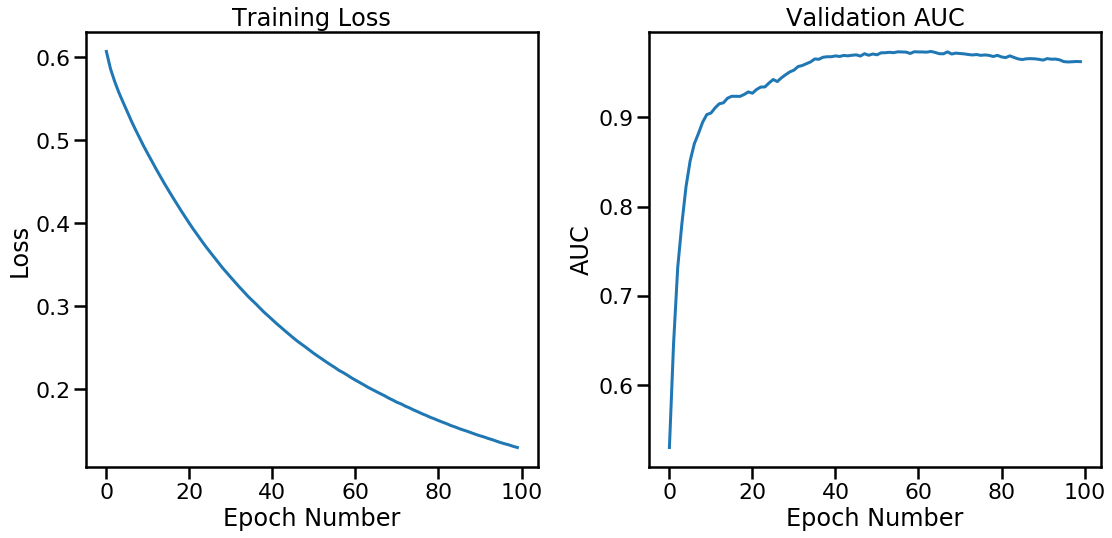

In [42]:
fig = plt.figure(figsize=(16, 8),constrained_layout=False)
ax = fig.add_subplot(121)
sn.lineplot(data=final_result, x='epoch', y='loss',
            ax=ax)
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Loss")
ax.set_title("Training Loss")


ax = fig.add_subplot(122)
sn.lineplot(data=final_result, x='epoch', y='accuracy',
            ax=ax)
ax.set_xlabel("Epoch Number")
ax.set_ylabel("AUC")
ax.set_title("Validation AUC")
plt.tight_layout()
plt.show()

## Model evaluation


In [43]:
out_val =model(test_X)
out_val = out_val[-1,:,:]
# pass through a softmax to tansform to probability
res = torch.nn.functional.softmax(out_val, dim=1)
y_pred = res[:,1]
y_score = y_pred.detach().cpu().numpy()

In [44]:
y_score.shape

(35550,)

In [45]:
y_true = target_signal_val[cut:].T
y_true.shape

(35550,)

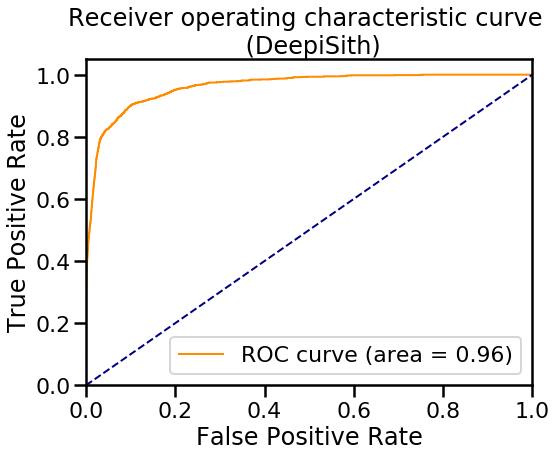

In [46]:
roc_auc = roc_auc_score(y_true = y_true,y_score = y_score)
fpr, tpr, _ = roc_curve(y_true = y_true,y_score = y_score)
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve \n (DeepiSith)')
plt.legend(loc="lower right")
plt.show()